# Strip-AI with ResNet CNN

## Overview
This notebook is a practice of building a Convolutional Neural Network(CNN) on top of a pretrained CNN model from TensorFlow and Keras to build a Convolutional Neural Network (CNN) to solve the challenge of detecting "the wwo major acute ischemic stroke (AIS) etiology subtypes: cardiac and large artery atherosclerosis". 
The competetion and data can be referred to the link at https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data#:~:text=Download-,All,-navigate_next.

The big challenge on this competition includes: there is not enough data for trainning and the each of the image file is too big to be loaded into memory.

This notebook can also be found at https://github.com/Lorby04/msds/tree/main/dl/week6 and https://www.kaggle.com/lorbybi/strip-ai-with-resnet-cnn/


In [1]:
# import required libraries
import pathlib
import os
import sys
import concurrent.futures

import pandas as pd
from PIL import Image

import numpy as np
import random as rn

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_io as tfio
import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer

# Constants and configuration

In [2]:
class Constants:
    QUICK_TEST = True
    MAX_FILES = 10000
    TARGET_SIZE = [1024,1024]
    BATCH_SIZE = 1
    
class Config():
    def __init__(self):
        self.dataset_url = "https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data#:~:text=Download-,All,-navigate_next"
        self.data_root_dir =  "/kaggle/input/mayo-clinic-strip-ai/"
        self.working_dir = "/kaggle/working/"
        self.temp_dir = "/kaggle/working/temp/"

        if os.path.exists("/kaggle"):
            print("Working in kaggle notebook enviorment")
        else:
            print("Working locally")
            self.data_root_dir =  "./asl-signs/"
            self.working_dir = data_root_dir
            self.temp_dir = working_dir

        self.temp_train_dir = self.temp_dir + "train/"
        self.temp_test_dir = self.temp_dir + "test/"
        
        self.data_dir = self.data_root_dir

        self.train_csv =  self.data_dir + "train.csv"
        self.test_csv = self.data_dir + "test.csv"
        self.other_csv = self.data_dir + "other.csv"

        self.origin_train_dir = self.data_dir + "train/"
        self.origin_test_dir = self.data_dir + "test/"

        self.train_dir = self.data_dir + "train/"
        self.test_dir = self.data_dir + "test/"
        self.other_dir = self.data_dir + "other/"

        self.dir_true = self.train_dir + "1/"
        self.dir_false = self.train_dir + "0/"

        self.origin_train_path = pathlib.Path(self.origin_train_dir).with_suffix('')
        self.origin_test_path = pathlib.Path(self.origin_test_dir).with_suffix('')

        self.train_path = pathlib.Path(self.train_dir).with_suffix('')
        self.test_path = pathlib.Path(self.test_dir).with_suffix('')
    
    def download_data(self):
        if not os.path.exists(self.data_dir):
            cmd = "pip install opendatasets"
            os.system(cmd)
            import opendatasets as od
            od.download(self.dataset_url)
        

In [3]:
config = Config()
config.download_data()

Working in kaggle notebook enviorment


# Exploratory Data Analysis

## Table
Downloads the csv files which inlcudes the information the image file and the result that the related image file indicates.
The training dataset include 700+ images which have been clearly diagnosised with either CE or LAA. Among which about 72.5% is diagnosised as CE. The other dataset include another 390 images which have been diagnosised with stroke other than CE and LAA.
In this notebook, the two datasets will be combined together for training.

In [4]:
class Df():
    def __init__(self, 
                 cfg:Config
                ):
        self.train_df = pd.read_csv(cfg.train_csv).dropna()
        self.test_df = pd.read_csv(cfg.test_csv)
        self.other_df = pd.read_csv(cfg.other_csv)
        self.other_df['label'] = self.other_df['label'].where(
            self.other_df['label']=='Unknown', 
            self.other_df['label']+'-'+ self.other_df['other_specified']
        )
        self.other_df.drop(['other_specified'], axis = 1, inplace=True)
        self.other_df.dropna(inplace = True)
        self.combined_train_df = None
        
    def combine_train_set(self):
        pass
    def glance_at(self, df):
        print("\nQuick view of {} data set".format(df))
        if df == 'train':
            print(self.train_df)
            self.train_df.info()
            print('Target values:')
            
            vc = self.train_df['label'].value_counts()     
            print(vc)
            plt.pie(vc,autopct='%1.1f%%')
            plt.legend(vc.index, loc='best')
            plt.show()
        elif df == 'test':
            print(self.test_df)
            self.test_df.info()
        else:
            print(self.other_df)
            self.other_df.info()
            print('Target values:\n')
            vc = self.other_df['label'].value_counts()     
            print(vc)
            plt.pie(vc,autopct='%1.1f%%')
            plt.legend(vc.index, loc='best')
            plt.show()
            
    def glance(self):
        self.glance_at('train')
        self.glance_at('test')
        self.glance_at('other')



Quick view of train data set
     image_id  center_id patient_id  image_num label
0    006388_0         11     006388          0    CE
1    008e5c_0         11     008e5c          0    CE
2    00c058_0         11     00c058          0   LAA
3    01adc5_0         11     01adc5          0   LAA
4    026c97_0          4     026c97          0    CE
..        ...        ...        ...        ...   ...
749  fe9645_0          3     fe9645          0    CE
750  fe9bec_0          4     fe9bec          0   LAA
751  ff14e0_0          6     ff14e0          0    CE
752  ffec5c_0          7     ffec5c          0   LAA
753  ffec5c_1          7     ffec5c          1   LAA

[754 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   i

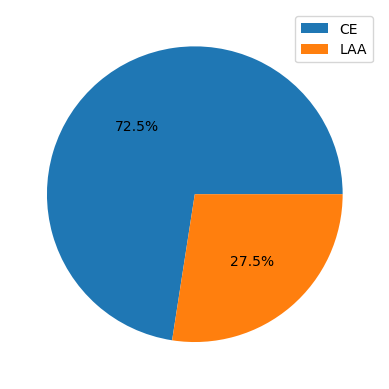


Quick view of test data set
   image_id  center_id patient_id  image_num
0  006388_0         11     006388          0
1  008e5c_0         11     008e5c          0
2  00c058_0         11     00c058          0
3  01adc5_0         11     01adc5          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes

Quick view of other data set
     image_id patient_id  image_num                  label
0    01f2b3_0     01f2b3          0                Unknown
1    01f2b3_1     01f2b3          1                Unknown
2    02ebd5_0     02ebd5          0                Unknown
3    0412ab_0     0412ab          0                Unknown
4    04414e_0     04414e  

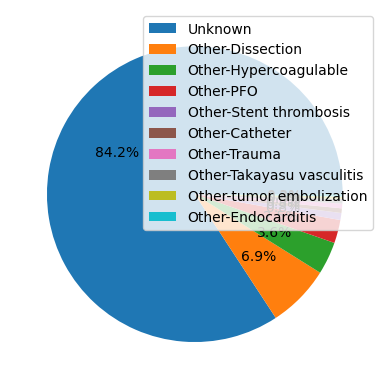

In [5]:
df = Df(config)
df.glance()

## Image files processing

### Preprocessing
The original image is in tiff format which is not well supported by tensorflow or tfio. Additionally,the image file is too big to load more than 2 files to memory to handle.
To solve the problem, some utilities are defined to handle. The utility load the original files to memory one by one, then convert the original file to a smaller jpg file to be saved to a temporary directory along with the label as subdir with utilities provided in package Pillow. For each file, the operation happens in a separated process, when one file is handled, the process will be terminated to recycle the memory, then the next one will be processed, etc...

The dimension of the original image is about 60k X 30k, to be fit in the model well, during the above procedure, the dimension is changed to 1024 X 1024.



In [6]:
class ImageRawDataInMemory:
    def __init__(self, 
                 df, 
                 path, 
                 dumypath,
                 target_size = Constants.TARGET_SIZE, 
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.path = path
        self.target_size = target_size
        self.max_images = min(len(df), Constants.MAX_FILES)
        self.quick_test = quick_test
        if (quick_test):
            self.max_images = min(4, len(df))
        self.imgs = [None]*self.max_images #List of (img, label, image_id)
        self.loaded_images = 0
        self.is_training = 'label' in df.columns
        
        
class ImageLoaderInMemory:
    def build(df, 
             path, 
             dumypath,
             target_size = Constants.TARGET_SIZE, 
             quick_test = Constants.QUICK_TEST):
        owner = ImageRawDataInMemory(df,
                                   path,
                                   dumypath,
                                   target_size,
                                   quick_test)
        
        loader = ImageLoaderInMemory(owner)
        loader.build_dataset(imgs,training_ratio)
        return loader
    
    def __init__(self,owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
    
    
    def load_image(self,file):
        backup = Image.MAX_IMAGE_PIXELS
        Image.MAX_IMAGE_PIXELS = None

        img = None
        with Image.open(file) as f:
            img = f.resize(self.owner().target_size,Image.Resampling.LANCZOS)

        Image.MAX_IMAGE_PIXELS = backup
        return img

    # The loading is done in a separated process
    # Since the notebook is designed to be run in sequencial mode, no lock is needed
    def load_one(self, id):
        fn = self.owner().path + str(id) + '.tif'
        img = None
        with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
            future = executor.submit(self.load_image, fn)
            img = future.result()
        return img
    
    # load all images in the specified directory, resize to small size, store the resized copy
    def load(self):       
        start = timer()

        self.owner().loaded_images = 0
        self.owner().imgs = [None]*self.owner().max_images
        
        loop_start = timer()
        indice = rn.sample(range(0, len(self.owner().df)), self.owner().max_images)
        for i in indice:
            img = self.load_one(self.owner().df.loc[i]['image_id'])
            if self.owner().quick_test:
                print("Loaded a image {}:{}".format(self.owner().df.loc[i]['image_id'],img))
            else:
                print('.', end = ' ')

            if self.owner().is_training:
                self.owner().imgs[self.owner().loaded_images] = [img, self.owner().df.loc[i]['image_id'], self.owner().df.loc[i]['label']]
            else:
                self.owner().imgs[self.owner().loaded_images] = [img, self.owner().df.loc[i]['image_id'], None]
                
            self.owner().loaded_images += 1
        
        elapsed = timer() - start

        print("{} images are loaded from {} in {} seconds".format(self.owner().loaded_images, self.owner().path, elapsed))
            
    def show_images(self):
        num = min(2, self.owner().loaded_images)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        indice = rn.sample(range(0, self.owner().loaded_images), num)
        print(indice)
        for i in range(len(indice)):
            img = self.owner().imgs[indice[i]]
            ax[i].imshow(img[0])
            ax[i].set_title(img[1]+ ('' if img[2]==None else ' '+img[2]))
            i += 1
            if i >= num:
                return
    
    def pick_one(self):
        if self.owner().loaded_images == 0:
            return None
        index = rn.sample(range(0, self.owner().loaded_images), 1)[0]
        return self.owner().imgs[index]
    
    def statistics(self):
        print("{} images are loaded from {}".format(self.owner().loaded_images, self.owner().path))

In [7]:
class DatasetInMemory:
    def __init__(self, imgs, training_ratio = 0.8):
        self.img_set = None # [[img_tensor, id, label]*N]
        self.size = 0
        for images in imgs:
            self.size += images.loaded_images
    
        self.tensors = [None]*self.size
        self.length = 0
        
        self.ds = None
        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None

        
class DatasetBuilderFromMemory:
    def build(imgs, training_ratio = 0.8):
        owner = DatasetInMemory(imgs, training_ratio)
        
        builder = DatasetBuilderFromMemory(owner)
        builder.build_dataset(imgs,training_ratio)
        return builder
    
    def __init__(self,owner=None):
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
                
        
    def build_dataset(self, imgs, training_ratio):
        self.owner().length = 0
        self.owner().tensors = [None]*self.owner().size
        self.owner().img_set = None
        for ims in imgs:
            if self.owner().img_set == None:
                self.owner().img_set = ims.imgs.copy()
            else:
                self.owner().img_set.extend(ims.imgs.copy())
        if self.owner().img_set[0][2] == None: # Test set, no labels ready
            pass
        for i in range(len(self.owner().img_set)):
            self.owner().img_set[i][0] = tf.convert_to_tensor(self.owner().img_set[i][0])
    
        
        img_list, id_list, label_list = zip(*self.owner().img_set)
        if label_list[0] != None:
            img_ds = tf.data.Dataset.from_tensor_slices(img_list)
            label_ds = tf.data.Dataset.from_tensors(label_list)
            self.owner().ds = tf.data.Dataset.zip(img_ds, label_ds)
            
            
            skip_count = int(training_ratio * (1-len(self.owner().img_set)))
            self.owner().train_ds_=self.owner().ds.skip(skip_count).batch(Constants.BATCH_SIZE)
            self.owner().val_ds_ = self.owner().ds.take(skip_count).batch(Constants.BATCH_SIZE)
        else:
            self.owner().ds = tf.data.Dataset.from_tensors((img_list))
            self.owner().test_ds_ = self.owner().ds.batch(Constants.BATCH_SIZE)
            
    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            #print(b)
            for img, label in b:
                ax[i].imshow(img)
                ax[i].set_title("Label:" + label)
                i += 1
                if i >= num:
                    return                

    def show_test_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            for img in b:
                ax[i].imshow(img)
                ax[i].set_title("Test image")
                i += 1
                if i >= num:
                    return  
                
    def show_images(self):
        if self.owner().train_ds_ != None:
            self.show_train_images(self.owner().train_ds_, 1)
            assert(self.owner().val_ds_ != None)
            self.show_train_images(self.owner().val_ds_,1)
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_images(self.owner().test_ds_, 2)
                
    def statistics(self):
        print(self.owner().imgs)
        print("Expected tensors:{}, real tensors:{}".format(self.owner().size, self.owner().length))

In [8]:
def check_create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        pass
   

class ImageRawDataInDisk:
    def __init__(self, 
                 df, 
                 from_path,
                 to_path,
                 target_size = Constants.TARGET_SIZE, 
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.from_path = from_path
        self.to_path = to_path
        self.target_size = target_size
        self.max_images = min(len(df), Constants.MAX_FILES)
        self.quick_test = quick_test
        if (quick_test):
            self.max_images = min(4, len(df))
        self.loaded_images = 0
        self.skipped_images = 0
        self.is_training = 'label' in df.columns
        
class ImageLoaderToDisk:    
    def build(df, 
             from_path,
             to_path,
             target_size = Constants.TARGET_SIZE, 
             quick_test = Constants.QUICK_TEST):
        owner = ImageRawDataInDisk(df, 
                 from_path,
                 to_path,
                 target_size, 
                 quick_test)
        check_create_dir(to_path)
        loader = ImageLoaderToDisk(owner)
        loader.load()
        return loader
    
    def __init__(self, owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
                
        
    def load_image(self, from_file, to_file):
        backup = Image.MAX_IMAGE_PIXELS
        Image.MAX_IMAGE_PIXELS = None

        with Image.open(from_file) as f:
            img = f.resize(self.owner().target_size,Image.Resampling.LANCZOS)
            img.save(to_file)

        Image.MAX_IMAGE_PIXELS = backup
        return True

    # The loading is done in a separated process
    # Since the notebook is designed to be run in sequencial mode, no lock is needed
    def load_one(self, from_file, to_file):
        success = False
        with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
            future = executor.submit(self.load_image, from_file, to_file)
            success = future.result()
        return success
    
    # load all images in the specified directory, resize to small size, store the resized copy
    def load(self):       
        start = timer()

        self.owner().loaded_images = 0
        self.owner().imgs = [None]*self.owner().max_images
        
        loop_start = timer()
        
        to_dir = self.owner().to_path
        indice = rn.sample(range(0, len(self.owner().df)), self.owner().max_images)
        for i in indice:
            id = self.owner().df.loc[i]['image_id']
            if self.owner().is_training:
                label = self.owner().df.loc[i]['label']
                to_dir = self.owner().to_path + label + "/"
            else:
                assert(to_dir == self.owner().to_path)

            check_create_dir(to_dir)
            to_file = to_dir + str(id) + ".jpg"
            if os.path.exists(to_file):
                self.owner().skipped_images += 1
                self.owner().loaded_images += 1
                continue
                
            from_file = self.owner().from_path + str(id) + '.tif'    
            self.load_one(from_file, to_file)
            self.owner().loaded_images += 1
            print('.', end = ' ')
        
        elapsed = timer() - start

        print("{} images are loaded from {} to {} in {} seconds, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, self.owner().to_path, elapsed,
            self.owner().skipped_images
        ))
            
    def show_images(self):
        files = None
        for dirname,_, filenames in os.walk(self.owner().to_path):
            for filename in filenames:
                fullname = os.path.join(dirname, filename)
                if files == None:
                    files = [fullname]
                else:
                    files.append(fullname)
                    
        num = min(2, len(files))
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        indice = rn.sample(range(0, len(files)), num)
        #print(indice)
        for i in range(len(indice)):
            with Image.open(files[indice[i]]) as img:
                ax[i].imshow(img)
                ax[i].set_title(files[indice[i]])
                i += 1
                if i >= num:
                    return
    
    def statistics(self):
        print("{} images are loaded from {} to {}, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, 
            self.owner().to_path, self.owner().skipped_images
        ))


In [9]:
class DatasetFromDisk:
    def __init__(self, imgs, training_ratio = 0.8):
        self.ds_from = imgs[0].to_path 
        assert(self.ds_from != None)
        self.is_training = imgs[0].is_training
        self.training_ratio = training_ratio if training_ratio > 0 and  training_ratio <= 1 else 0.8

        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None
        
        self.is_preprocessed = False
        
        
class DatasetBuilderFromDisk:
    def build(imgs, training_ratio = 0.8):
        owner = DatasetFromDisk(imgs, training_ratio)
        
        builder = DatasetBuilderFromDisk(owner)
        builder.build_dataset()
        return builder
    
    def __init__(self,owner = None): # MUST set owner before using
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner

    
    def build_dataset(self):
        if self.owner().is_training:
            self.owner().train_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="training",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle=True
            )
        
            self.owner().val_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="validation",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle = True
            )
        else:
            pass
        self.pre_process()

    def pre_process(self):
        return #Don't perform preprocess
        if self.owner().is_preprocessed:
            return
        
        preprocessor = tf.keras.Sequential(
            [
                tf.keras.layers.Rescaling(scale=1./255),
            ]
        )
        
        if self.owner().train_ds_ != None :
            self.owner().train_ds_  = self.owner().train_ds_.map(lambda x, y: (preprocessor(x), y))
            
        if self.owner().val_ds_ != None :
            self.owner().val_ds_  = self.owner().val_ds_.map(lambda x, y: (preprocessor(x), y))
        
        if self.owner().test_ds_ != None :
            self.owner().test_ds_  = self.owner().test_ds_.map(lambda x, y: (preprocessor(x), y))
        
        self.owner().is_preprocessed = True
        return

    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for imgs, labels in ds:
            #print(imgs)
            #print(labels)
            for img in imgs:
                iax = ax
                if num > 1:
                    iax = ax[i]
                
                iax.imshow(img.numpy().astype("uint8"))
                #iax.set_title("Label:" + label)
                i += 1
                if i >= num:
                    return                

    def show_test_images(self, ds, number):
        assert(ds != None and number >= 1)
        num = min(2, number)
        fig = plt.figure(figsize=(16,16))
        fig_width = 1
        fig_height = num
        ax = fig.subplots(fig_height,fig_width)
        
        i = 0
        for b in ds:
            for img in b:
                iax = ax
                if num > 1:
                    iax = ax[i]
                iax.imshow(img.numpy().astype("uint8"))
                iax.set_title("Test image")
                i += 1
                if i >= num:
                    return  
                
    def show_images(self):
        if self.owner().train_ds_ != None:
            self.show_train_images(self.owner().train_ds_, 1)
            assert(self.owner().val_ds_ != None)
            self.show_train_images(self.owner().val_ds_,1)
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_images(self.owner().test_ds_, 2)
                
    def statistics(self):
        print(self.owner().imgs)
        print("Expected tensors:{}, real tensors:{}".format(self.owner().size, self.owner().length))

In [10]:
# Use alias to try different options
ImageData = ImageRawDataInDisk
ImageLoader = ImageLoaderToDisk
Dataset = DatasetFromDisk
DatasetBuilder = DatasetBuilderFromDisk

In [11]:
train_images = ImageLoader.build(df.train_df, config.train_dir, config.temp_train_dir).owner()

. . . . 4 images are loaded from /kaggle/input/mayo-clinic-strip-ai/train/ to /kaggle/working/temp/train/ in 170.16385834599998 seconds, 0 are skipped among which.


In [12]:
train_image_loader = ImageLoader(train_images)

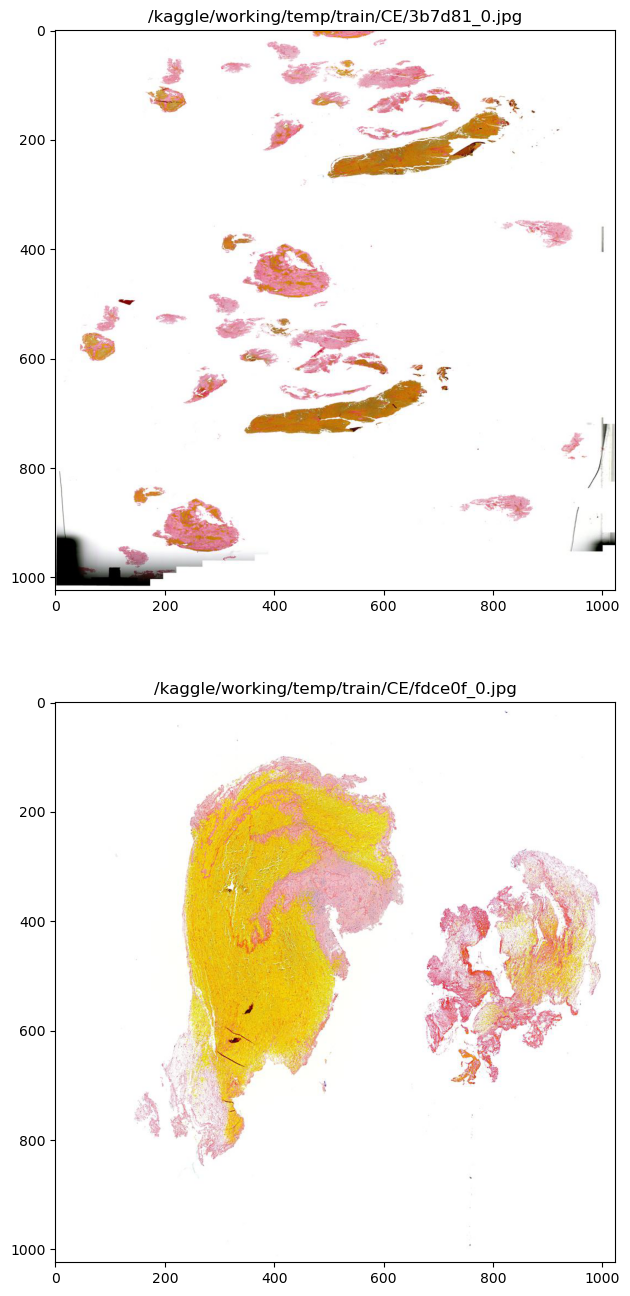

In [13]:
train_image_loader.show_images()

In [14]:
other_images = ImageLoader.build(df.other_df, config.other_dir, config.temp_train_dir).owner()

. . . . 4 images are loaded from /kaggle/input/mayo-clinic-strip-ai/other/ to /kaggle/working/temp/train/ in 173.18100101200002 seconds, 0 are skipped among which.


In [15]:
other_image_loader = ImageLoader(other_images)

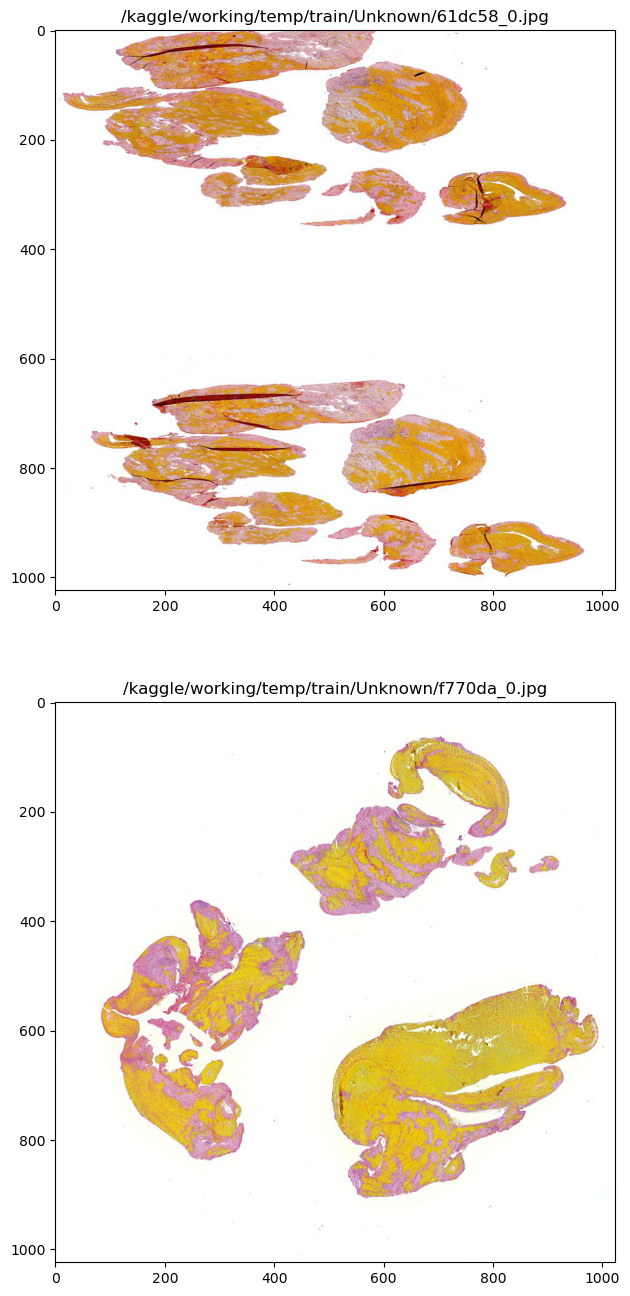

In [16]:
other_image_loader.show_images()

### Prepare tensorflow dataset
Create tensorflow dataset for training with the Keras API "image_dataset_from_directory()" to create tensorflow dataset from the directory. The label is the name of sundir.

In [17]:
ds = DatasetBuilder.build([train_images, other_images]).owner()

Found 8 files belonging to 2 classes.
Using 7 files for training.
Found 8 files belonging to 2 classes.
Using 1 files for validation.


In [18]:
ds_loader = DatasetBuilder(ds)

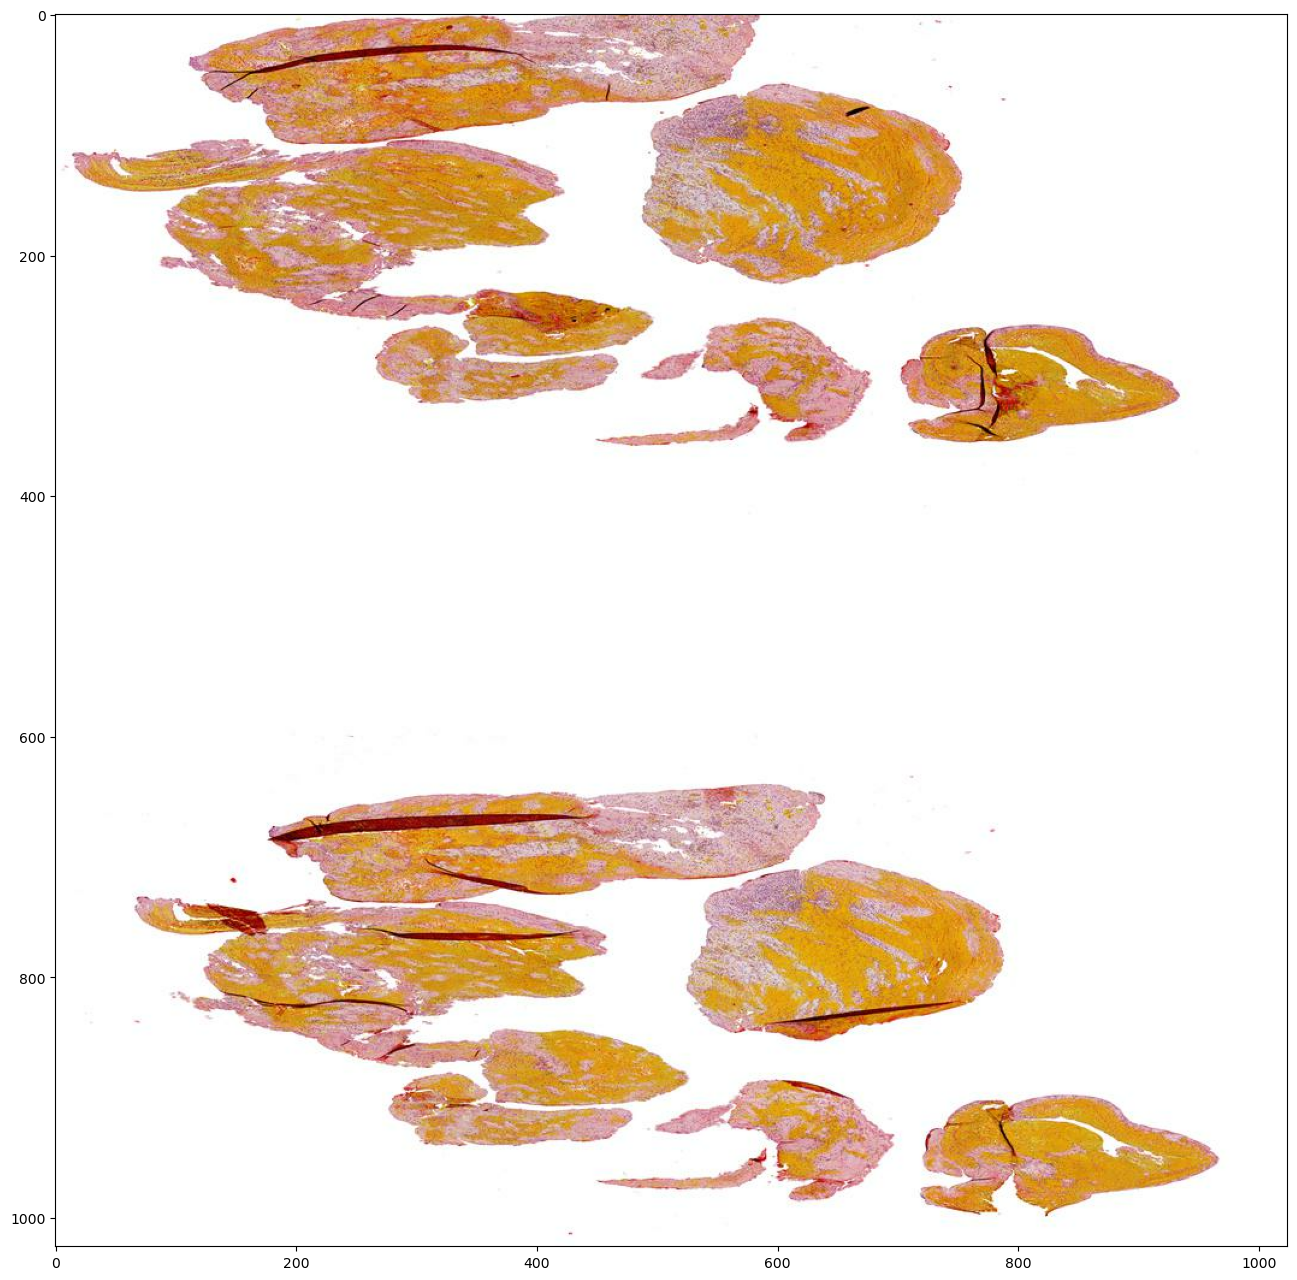

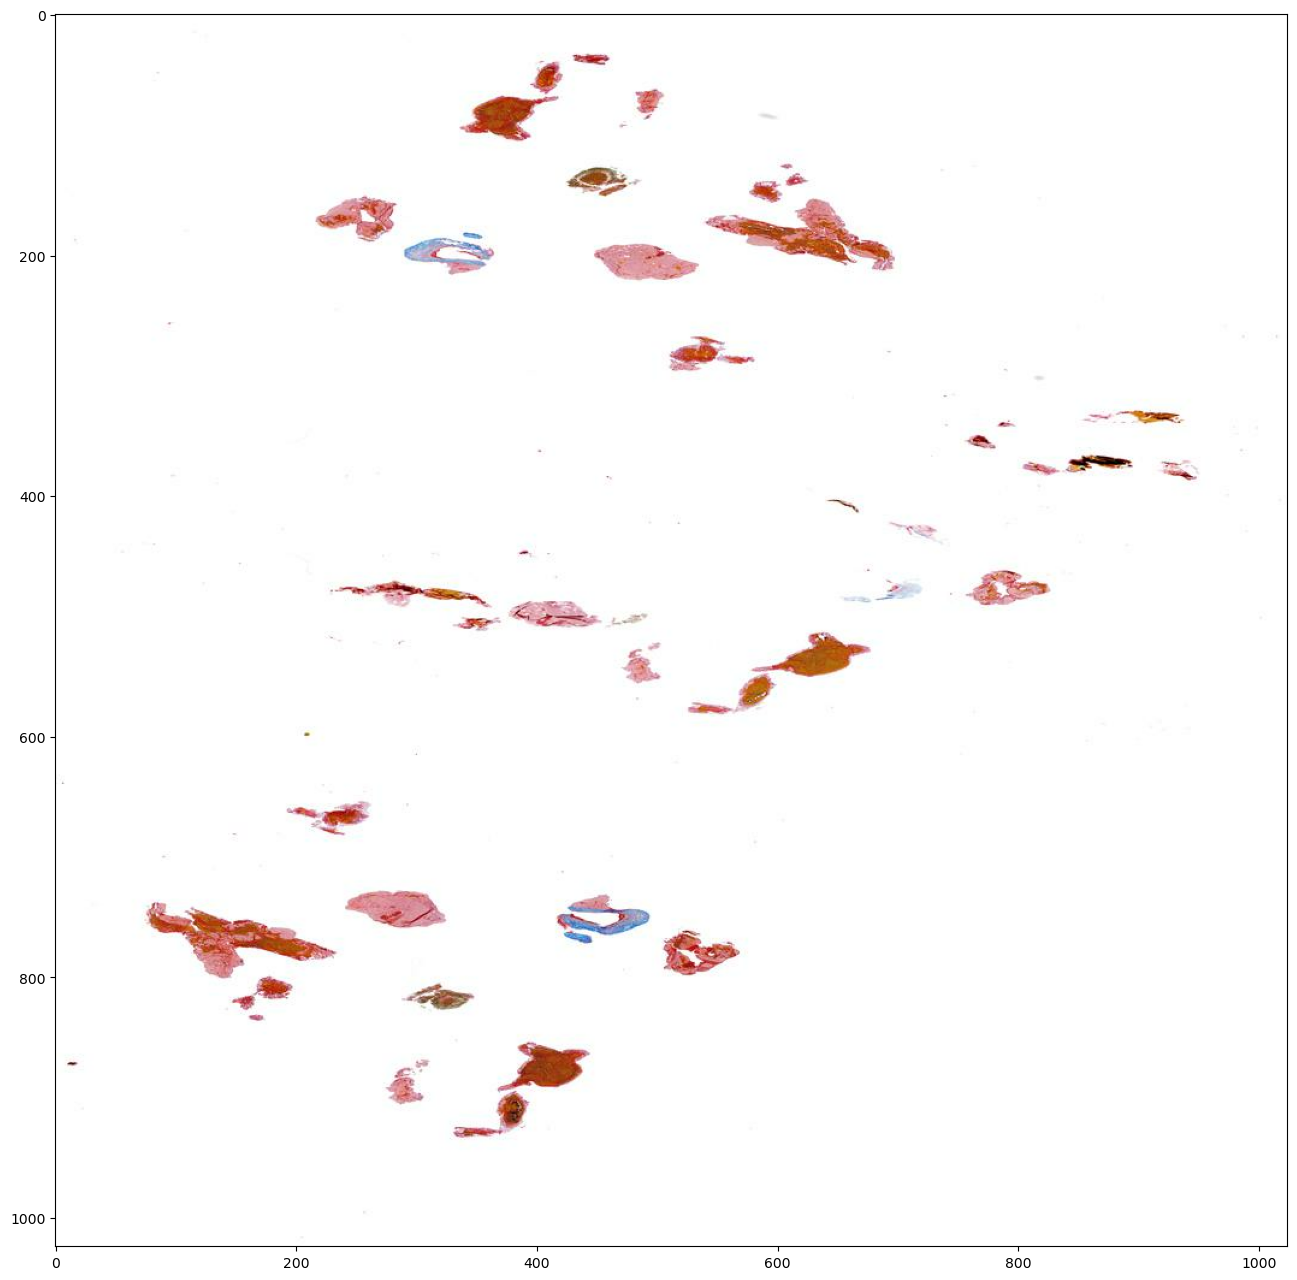

In [19]:
ds_loader.show_images()

In [20]:
ds.train_ds_.class_names

['CE', 'Unknown']

# Build Model And Train
The core model is based on the pretrained ResNet50V2. Due to the restriction of kaggle environment, it is not feasible to retrain the base model, so the base model is set to untrainable.
Here is the summary of the models:
1. Input and augument (rotation, flip plus with zoom) layer
2. Core model: ResNet50V2 from tensorflow.keras.application, refer to "Identity Mappings in Deep Residual Networks (CVPR 2016)"
3. Output layer with 2 more full mesh dense layers.
4. Optimization algorithm: Adam
5. Activation function: relu
6. Callbacks: Early stop if val_accurancy decreases in two consecutive epochs.

Train with the dataset created in the previous procedure.

In [21]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
class Model:
    def __init__(self, ds):
        self.ds = ds
        self.history = None        
        self.opt = Adam()
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metrics = ['accuracy']
        self.callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

        self.model = self.build_model()
        
    def fit(self, ds = None, epochs = 10):
        if ds == None:
            ds = self.ds
        self.history = self.model.fit(
            ds.train_ds_, 
            validation_data = ds.val_ds_,
            epochs = epochs,
            callbacks = self.callbacks
        )

     
    def build_model(self):
        # Input and augment layers
        input_shape = ds.train_ds_.element_spec[0].shape[1:]
        i = tf.keras.layers.Input(shape=input_shape)
        x = tf.cast(i, tf.float32)
        x = tf.keras.layers.RandomRotation(0.2)(x)
        x = tf.keras.layers.RandomFlip()(x)
        x = tf.keras.layers.RandomZoom(0.2)(x)
        
        #Core processing layers, pre-trained
        base_model = ResNet50V2(include_top = False, classes = len(self.ds.train_ds_.class_names))
        base_model.trainable = False      
        x = preprocess_input(x) 
        x = base_model(x,training = False)
        
        #Output layers
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        o = tf.keras.layers.Dense(len(self.ds.train_ds_.class_names))(x)
        
        m = tf.keras.Model(i,o)
        m.compile(
            optimizer = self.opt,
            loss = self.loss,
            metrics = self.metrics
        )
        return m


In [44]:
class ModelVisualization:
    def __init__(self, model: Model):
        self.model = model
    
    def show_history(self):
        history = self.model.history.history
        fig = plt.figure(figsize=(6,10))
        fig_width = 1
        fig_height = 2
        ax = fig.subplots(fig_height,fig_width)
        
        ax[0].plot(history['accuracy'],'*-')
        ax[0].plot(history['val_accuracy'],"x-")
        ax[0].legend(['train', 'validation'])
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel('accuracy')
        ax[0].set_title("Accuracies")
        
        
        ax[1].plot(history['loss'],'*-')
        ax[1].plot(history['val_loss'],'x-')
        ax[1].legend(['train', 'validation'])
        ax[1].set_title("Losses")
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel('loss')
        plt.show()

In [25]:
m = Model(ds)

94668760/94668760 [==============================] - 1s 0us/step


In [31]:
m.fit(epochs = 3)

Epoch 1/3
7/7 [==============================] - 25s 4s/step - loss: 148.3709 - accuracy: 0.5714 - val_loss: 525.5405 - val_accuracy: 0.0000e+00
Epoch 2/3
7/7 [==============================] - 45s 7s/step - loss: 221.7793 - accuracy: 0.4286 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
7/7 [==============================] - 25s 4s/step - loss: 119.1363 - accuracy: 0.7143 - val_loss: 0.1091 - val_accuracy: 1.0000


Display the history of the training result.

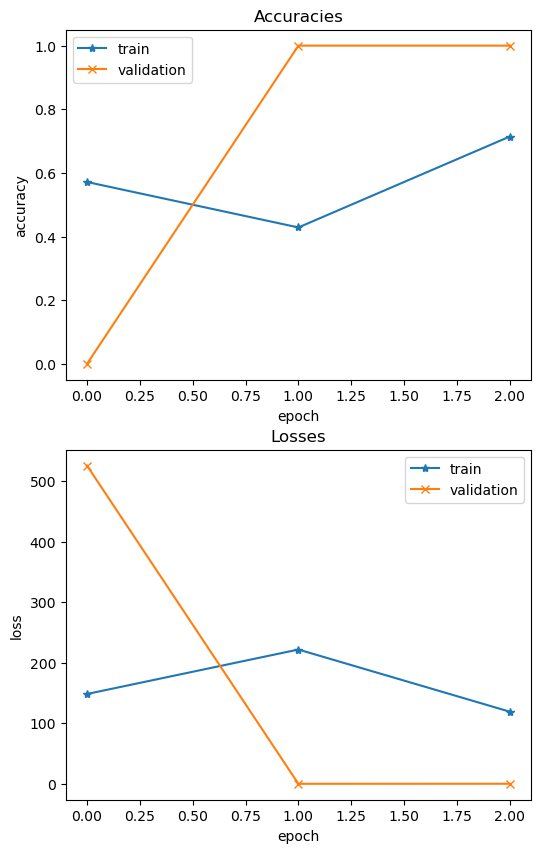

In [45]:
vm = ModelVisualization(m)
vm.show_history()

# Test
Same process as dealing with the training images, the testing images are loaded/resized then saved with jpg to a temporary directory.
Afte the preprocessing, a dataset for testing is created, then it is trained with the trained model. Submit the final result as requested.

Note: The competition requires to have the possibility of each type of the desease for every instance.

In [51]:
class Predictor:
    def __init__(self, model: tf.keras.Model, from_path, to_path, classes):
        self.model = model
        self.classes = classes
        #self.model.add(tf.keras.layers.Softmax())
        self.from_path = from_path
        self.to_path = to_path
        self.df = None
        self.prepare()
        self.pred = self.predict()
        self.pred_df = None
        self.build_result_df()
        
        self.submit()
    def prepare(self):
        test_files = np.array(os.listdir(self.from_path))
        self.df = pd.DataFrame(test_files, columns=['image_id'])
        self.df = self.df.applymap(lambda x: os.path.splitext(x)[0])
        ImageLoader.build(self.df, self.from_path, self.to_path)
        
    def predict(self):
        test_files = np.array(os.listdir(self.to_path))
        self.df = pd.DataFrame(test_files, columns=['image_id'])
        ds_gen = tf.keras.preprocessing.image.ImageDataGenerator()
        ds = ds_gen.flow_from_dataframe(
            self.df,
            self.to_path,
            class_mode=None,
            shuffle= False,
            x_col = 'image_id',
            y_col = None,
            target_size = Constants.TARGET_SIZE
        )

        y_pred_prob = self.model.predict(ds)
        #y_pred = tf.keras.np_utils.probas_to_classes(y_pred_prob)
        return tf.keras.activations.softmax(tf.convert_to_tensor(y_pred_prob))
    
    def build_result_df(self):
        self.df = self.df.applymap(lambda x: os.path.splitext(x)[0])
        self.pred_df = pd.DataFrame(self.pred.numpy(),columns=self.classes)
        d = dict(zip(df.test_df['image_id'], df.test_df['patient_id']))
        self.pred_df['patient_id'] = self.df.applymap(lambda x:d[x])
        self.pred_df.insert(0, 'patient_id', self.pred_df.pop('patient_id'))
  
    def submit(self):
        self.pred_df.to_csv('submission.csv',index=False)
        
    def dump(self):
        print("Prediction possibilities:")
        print(self.pred_df)
        

In [53]:
predictor = Predictor(m.model, config.origin_test_dir, config.temp_test_dir, ds.train_ds_.class_names)

4 images are loaded from /kaggle/input/mayo-clinic-strip-ai/test/ to /kaggle/working/temp/test/ in 0.0010363170001710387 seconds, 4 are skipped among which.
Found 4 validated image filenames.
1/1 [==============================] - 8s 8s/step


In [55]:
predictor.dump()

Prediction possibilities:
  patient_id            CE  Unknown
0     00c058  1.000000e+00      0.0
1     01adc5  0.000000e+00      1.0
2     008e5c  1.000000e+00      0.0
3     006388  3.483275e-18      1.0


## Conclusion and Analysis
The main challenge for this competition is how to handle the big files,with the tricky of using sepated process, the problem is solved, but the performance becomes worse.

To running this kind of analisys in production system, it needs to be redesigned with better scalability.

Another challenge is the data for training is too less which makes the result not being accurate enough.

Some improvements can be fullfiled:
1. Use tiff format directly.
2. Try with different models 
3. Add more training pictures
4. Run on more powerful server/cluster